# Описание Датасета:
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризация домашнего адреса
* work_address - категоризация рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту 

# Import

In [43]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from imblearn.under_sampling import RandomUnderSampler
import warnings


# Functions

In [44]:
def education_num(value):
    if value == 'SCH':
        return 1
    elif value == 'GRD':
        return 2
    elif value == 'UGR':
        return 3
    elif value == 'PGR':
        return 4
    elif value == 'ACD':
        return 5
    else:
        return 0

In [45]:
def cross_plot(series_1, series_2):
    pt = pd.crosstab([series_1], series_2)
    display(pt)
    pt.plot(kind='bar', title=series_2.name)

In [46]:
def time(value):
    date = datetime.strptime(value, '%d%b%Y')
    return date.timestamp()

In [47]:
def num_hist(series):
    plt.figure()
    sns.distplot(series)
    plt.title(series.name)
    plt.show()

In [48]:
def get_boxplot(data, column):
    for col in list_numeric:
        fig, ax = plt.subplots(figsize = (14, 4))
        ax.set_title('Boxplot for ' + col)
        sns.boxplot(x=data[col])

In [49]:
def log_num(data, columns):
    for col in columns:
        data[col] = data[col].apply(lambda x: np.log(x+1))
    return data

In [50]:
def heatmap(data, columns, method):
    corr = data[columns].corr(method=method)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(10, 10))
        ax = sns.heatmap(corr, mask=mask, annot=True, square=True, vmin=0, vmax=1)

In [51]:
def increase_data(data):
    data_contact = data[data.default == 1]
    for n in range(1,11):
        data = pd.concat([data, data_contact])

In [52]:
def removal_condition(values):
    global lower_lim
    global upper_lim
    if values < lower_lim:
        return lower_lim
    elif values > upper_lim:
        return upper_lim
    else:
        return values

In [53]:
def remove_outliers(data, columns):
    global lower_lim
    global upper_lim
    for col in columns:
        Q3 = np.quantile(data[col], 0.75)
        Q1 = np.quantile(data[col], 0.25)
        IQR = Q3 - Q1
        lower_lim = Q1 - (1.5 * IQR)
        upper_lim = Q3 + (1.5 * IQR)
        data[col] = data[col].apply(removal_condition)
    return data

# Data

In [54]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [55]:
warnings.filterwarnings("ignore")

In [56]:
#DATA_DIR = '/kaggle/input/sf-scoring/'
DATA_DIR = './data'
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [57]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [58]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [59]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['default'] = 0 
data = df_test.append(df_train, sort=False).reset_index(drop=True)

# EDA

In [60]:
data.sample(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
100486,89648,06APR2014,SCH,M,23,N,N,2,0,-1.026857,4,50,2,3,27000,1,4,N,1,0
31990,80966,28MAR2014,GRD,F,59,Y,Y,0,0,-1.848426,2,80,2,3,70000,1,4,N,0,0
17696,28138,04FEB2014,GRD,M,36,Y,Y,0,1,-1.908744,3,50,2,3,47000,1,4,Y,0,0
22054,17009,24JAN2014,SCH,M,38,N,N,2,0,-1.715767,0,50,2,3,12000,2,3,N,0,0
94379,96212,12APR2014,GRD,M,49,Y,N,0,0,-2.545738,2,50,2,3,35000,1,4,N,1,0
67573,79089,27MAR2014,GRD,F,61,N,N,0,1,-1.612319,0,80,2,3,60000,1,4,N,1,0
11654,21760,29JAN2014,UGR,M,37,Y,N,0,0,-2.691949,1,50,1,2,60000,3,2,N,0,0
102391,22814,30JAN2014,GRD,F,36,N,N,0,0,-1.757723,0,50,1,1,15000,1,4,N,1,0
50593,52926,01MAR2014,GRD,M,45,N,N,0,0,-1.788334,0,60,2,3,150000,1,4,N,1,0
71821,88153,04APR2014,UGR,M,27,N,N,0,0,-1.968643,2,60,2,3,30000,4,1,N,1,0


In [61]:
data.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

Как видно имеются бинарные переменные: 
* sex
* car
* car_type
* good_work
* foreign_passport

In [62]:
list_binary = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [63]:
list_other_columns = set.difference(set(data.columns), set(list_binary), {'default', 'sample'})
for i in list_other_columns:
    print(f'column:                \033[32m{i}\033[0m')
    print(f'Колличество значений:  {data[i].nunique()}')
    print(f'Уникальные значения:   {data[i].unique()}\n')

column:                sna
Колличество значений:  4
Уникальные значения:   [1 4 2 3]

column:                region_rating
Колличество значений:  7
Уникальные значения:   [50 40 80 60 70 20 30]

column:                bki_request_cnt
Колличество значений:  40
Уникальные значения:   [ 3  2  1  0  7  5  4  6  9  8 12 10 17 13 11 14 15 19 27 18 16 29 21 20
 47 22 23 25 33 24 32 40 26 28 34 36 53 45 41 46]

column:                first_time
Колличество значений:  4
Уникальные значения:   [4 3 1 2]

column:                work_address
Колличество значений:  3
Уникальные значения:   [2 3 1]

column:                age
Колличество значений:  52
Уникальные значения:   [29 39 50 56 38 55 30 41 34 28 32 37 43 27 46 52 49 53 36 61 25 24 42 51
 33 45 44 47 23 22 48 31 40 57 65 59 35 21 64 26 67 63 66 68 60 54 58 69
 62 70 71 72]

column:                income
Колличество значений:  1207
Уникальные значения:   [ 50000   5000  30000 ...  54810  10670 100600]

column:                app_date
Колличес

Из остальных переменных можно выделить

категориальные переменные:
* home_address
* decline_app_cnt
* first_time
* education
* region_rating
* sna
* work_address

числовые переменные:
* income
* score_bki
* age
* bki_request_cnt

даты:
* app_date

client_id не имеет смысла для модели

In [64]:
list_сategorical = ['home_address', 'decline_app_cnt', 'first_time', 
                    'education', 'region_rating', 'sna', 'work_address']
list_numeric = ['income', 'score_bki', 'age', 'bki_request_cnt']

Отношение значений default: 10.75


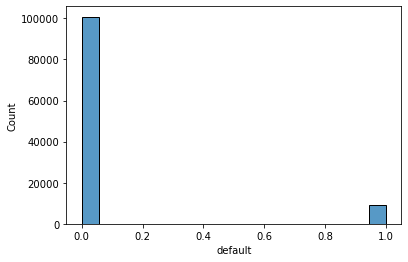

In [65]:
sns.histplot(data.default)
print(f'Отношение значений default: {round(len(data[data.default == 0]) / len(data[data.default == 1]), 2)}')

Имеется дисбаланс признаков. 
Скопируем default = 1 10 раз

In [66]:
data_contact = data[data.default == 1]
for n in range(1,11):
    data = pd.concat([data, data_contact])

Отношение значений default: 0.98


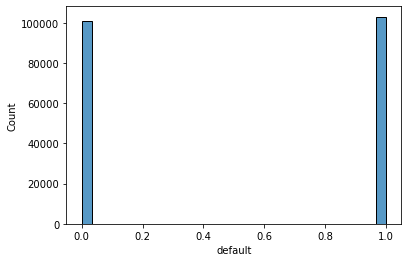

In [67]:
sns.histplot(data.default)
print(f'Отношение значений default: {round(len(data[data.default == 0]) / len(data[data.default == 1]), 2)}')

home_address,1,2,3
default,,,
0,45661,53392,1723
1,33297,68189,1606


decline_app_cnt,0,1,2,3,4,5,6,7,8,9,...,14,15,16,19,20,21,22,24,30,33
default,,,,,,,,,,,,,,,,,,,,,
0,84766,10923,3021,1118,486,212,122,44,27,20,...,2,0,3,0,1,1,0,1,1,1
1,73755,17347,6611,2717,1320,473,374,154,110,99,...,11,11,0,11,0,0,11,0,0,0


first_time,1,2,3,4
default,,,,
0,16018,15449,42829,26480
1,25058,19778,41349,16907


education,ACD,GRD,PGR,SCH,UGR
default,,,,,
0,283,32663,1784,52146,13457
1,88,23155,891,64372,14201


region_rating,20,30,40,50,60,70,80
default,,,,,,,
0,269,377,15906,37234,21928,8731,16331
1,484,627,22451,41217,22781,6303,9229


sna,1,2,3,4
default,,,,
0,66036,14240,5504,14996
1,51095,17512,7150,27335


work_address,1,2,3
default,,,
0,11656,28659,60461
1,6798,23122,73172


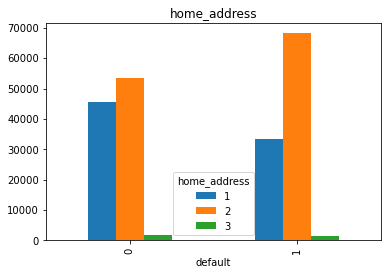

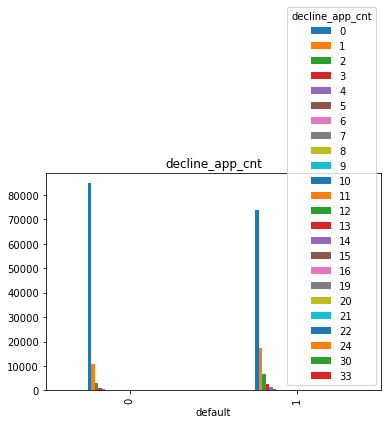

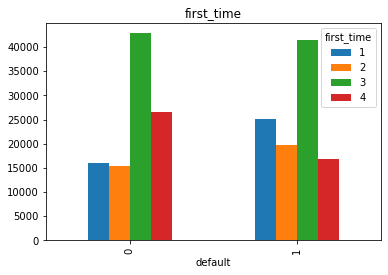

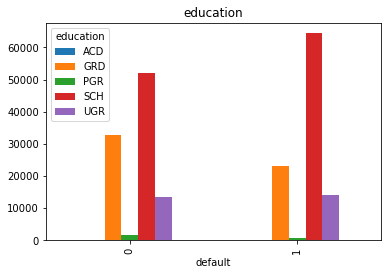

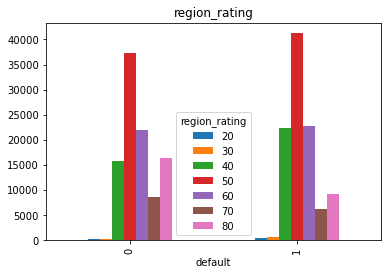

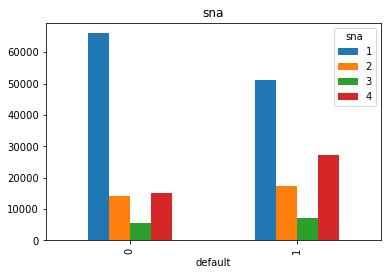

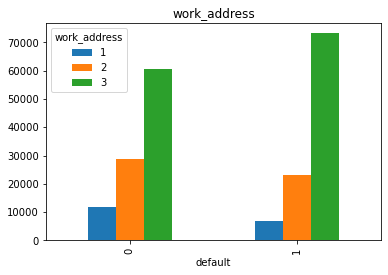

In [68]:
for col in list_сategorical:
    cross_plot(data.default, data[col])

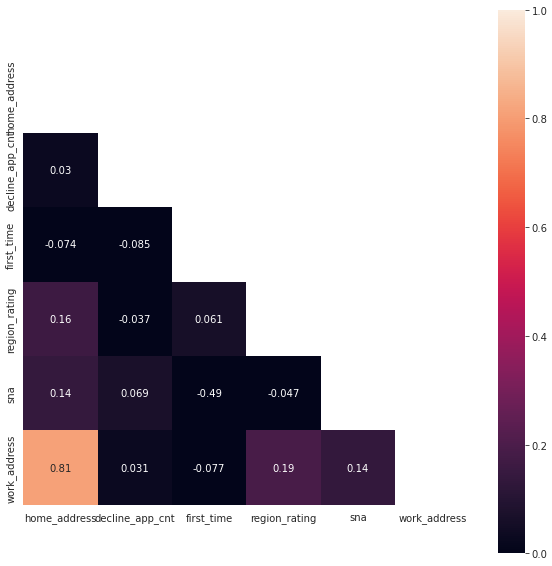

In [69]:
heatmap(data, list_сategorical, 'spearman')

Из распределения данных относительно default видно, что все категориальные переменные имеют значимые отклонения для default=0 и default=1. Также видно, что education имеет строковый вид.

Из распределения данных относительно default видно, что все категориальные переменные имеют значимые отклонения для default=0 и default=1. Также видно, что education имеет строковый вид.

Высокая корреляцияя между home_address и work_address

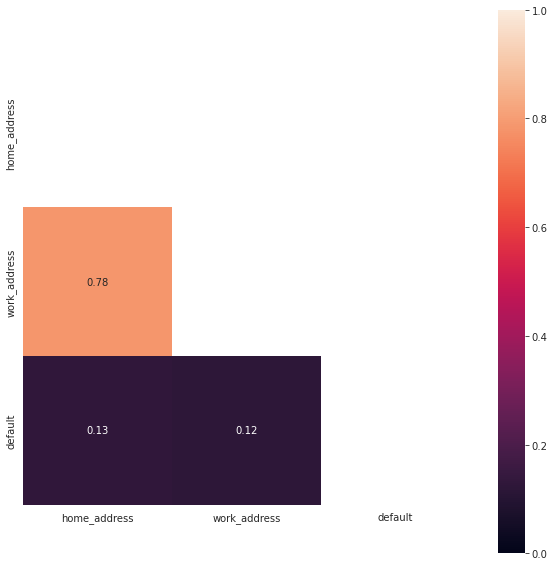

In [70]:
heatmap(data, ['home_address', 'work_address', 'default'], 'kendall')

Для построения модели примем home_address

Посмотрим на переменную app_date

In [71]:
data.app_date = data.app_date.apply(lambda x: datetime.strptime(x, '%d%b%Y'))

In [72]:
data['month'] = data.app_date.apply(lambda x: int(x.month))
data['day'] = data.app_date.apply(lambda x: int(x.day))

month,1,2,3,4
default,,,,
0,22781,24706,28896,24393
1,26477,26301,29711,20603


day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
default,,,,,,,,,,,,,,,,,,,,,
0,2676,2478,3473,3481,3311,3058,3317,2501,2939,3540,...,3395,2625,3725,3226,2886,3600,3954,2315,2540,2309
1,2871,2772,3795,3839,3036,3894,3575,2706,3025,3256,...,3399,3014,3410,3377,2805,3564,4224,2618,2574,2464


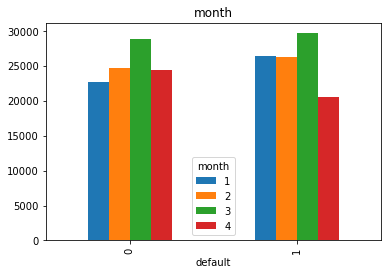

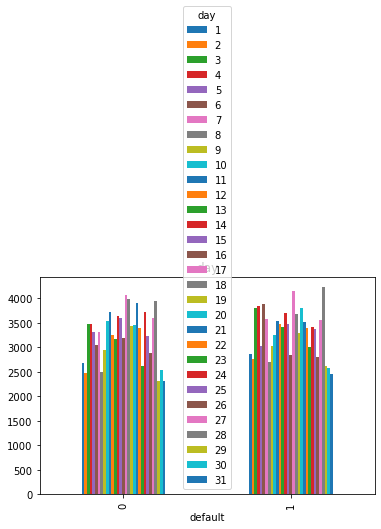

In [73]:
cross_plot(data.default, data.month)
cross_plot(data.default, data.day)

Как видно из данных распределение month и day относительно default:
* month имеет значимые расхождения
* расхождение day незначительны

Посмотрим на бинарные переменные

sex,F,M
default,,
0,56797,43979
1,55429,47663


car,N,Y
default,,
0,67465,33311
1,75075,28017


car_type,N,Y
default,,
0,80993,19783
1,89617,13475


good_work,0,1
default,,
0,83695,17081
1,90442,12650


foreign_passport,N,Y
default,,
0,85169,15607
1,94072,9020


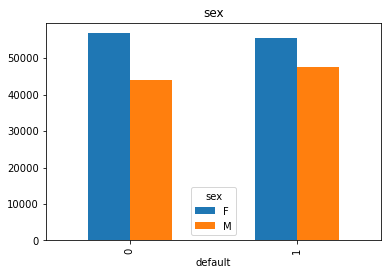

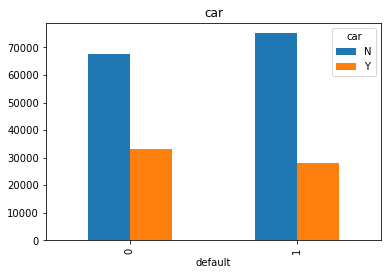

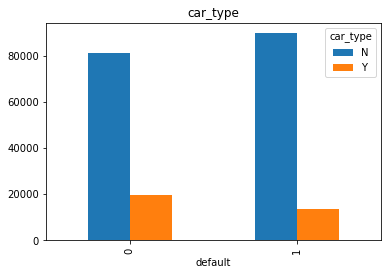

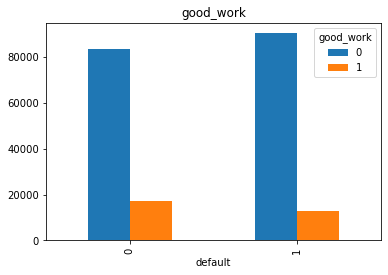

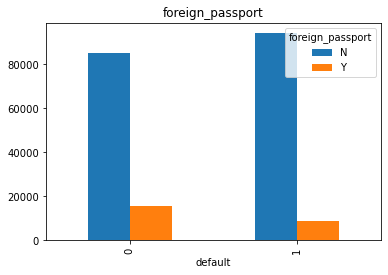

In [74]:
for col in list_binary:
    cross_plot(data.default, data[col])

Переведем бинарные переменные в числа

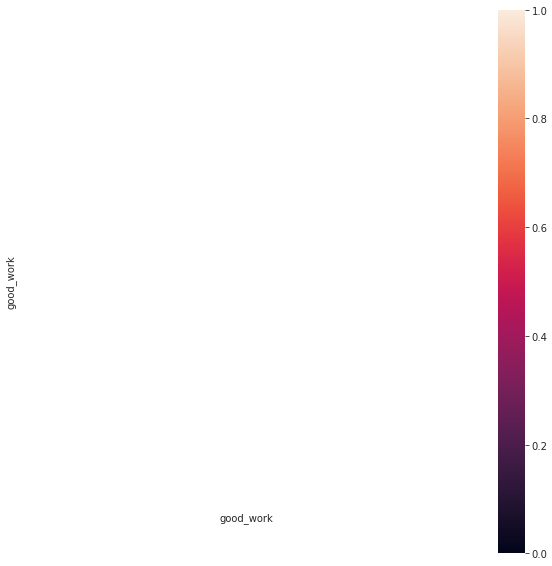

In [75]:
heatmap(data, list_binary, 'spearman')

In [76]:
label_encoder = LabelEncoder()
for col in list_binary:
    data[col] = label_encoder.fit_transform(data[col])
data.head(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,month,day
0,74835,2014-03-22,GRD,1,29,1,1,0,0,-2.271884,...,1,2,50000,1,4,0,0,0,3,22
1,17527,2014-01-24,SCH,0,39,0,0,5,0,-1.504999,...,1,2,5000,4,3,0,0,0,1,24
2,75683,2014-03-23,UGR,1,50,1,1,0,0,-1.691339,...,1,2,30000,1,3,1,0,0,3,23
3,26883,2014-02-03,SCH,1,56,0,0,0,0,-2.374182,...,1,2,17000,1,3,0,0,0,2,3
4,28862,2014-02-04,GRD,0,38,0,0,0,0,-2.487502,...,2,3,120000,1,3,0,0,0,2,4
5,99881,2014-04-17,SCH,0,55,0,0,0,0,-1.740224,...,3,3,30000,2,1,0,0,0,4,17
6,26630,2014-02-02,SCH,0,30,0,0,3,0,-1.387847,...,1,2,11000,4,3,0,0,0,2,2
7,79934,2014-03-28,GRD,1,41,1,1,0,0,-3.066047,...,1,3,80000,4,1,0,0,0,3,28
8,16605,2014-01-23,GRD,1,34,0,0,0,0,-3.117086,...,2,3,5000,1,2,0,0,0,1,23
9,105449,2014-04-24,UGR,1,28,1,1,0,0,-2.185172,...,2,3,80000,1,3,1,0,0,4,24


In [77]:
sort_corr = data.corr()
sort_corr = sort_corr.default.apply(lambda x: np.abs(x))
sort_corr.sort_values(ascending=False)

default             1.000000
sample              0.471138
score_bki           0.245194
sna                 0.168572
first_time          0.148389
decline_app_cnt     0.135549
region_rating       0.132820
home_address        0.124654
work_address        0.122093
foreign_passport    0.103361
bki_request_cnt     0.099994
car_type            0.088763
good_work           0.066280
car                 0.064078
income              0.059935
client_id           0.055636
month               0.052459
age                 0.034365
sex                 0.026063
day                 0.008756
Name: default, dtype: float64

<AxesSubplot:>

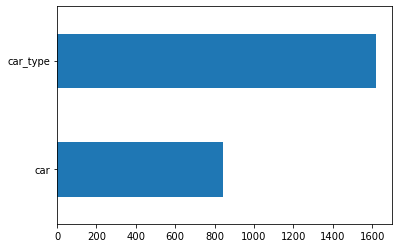

In [78]:
bin_to_num = pd.Series(f_classif(data[['car_type', 'car']], data['default'])[0], index = ['car_type', 'car'])
bin_to_num.sort_values(inplace = True)
bin_to_num.plot(kind = 'barh')

Как видно бинарные переменные имеют не значительные изменения относительно default. Имеются две связянные переменные: car_type, car. Предпочтительно взять car_type для обучения 

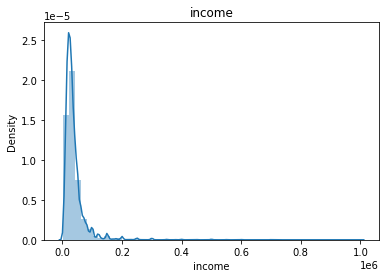

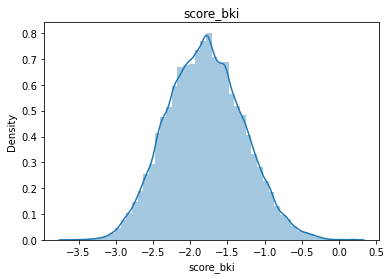

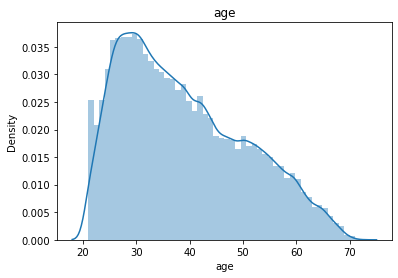

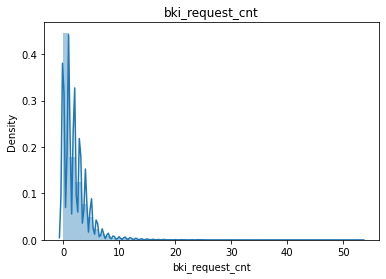

In [79]:
for col in list_numeric:
    num_hist(data[col])

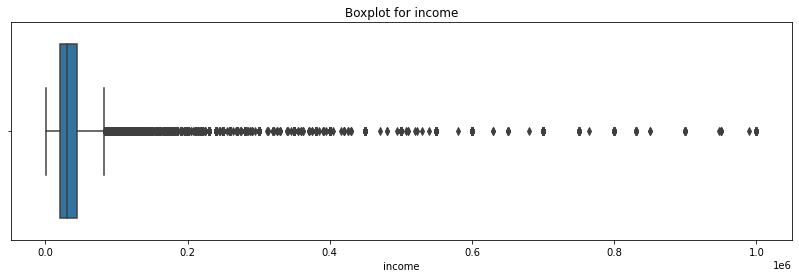

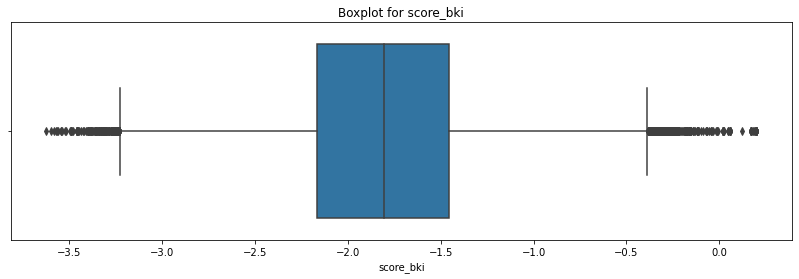

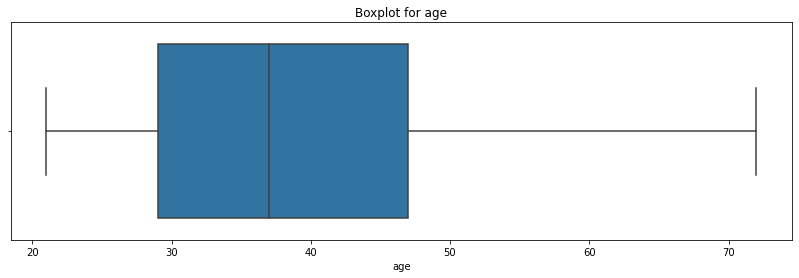

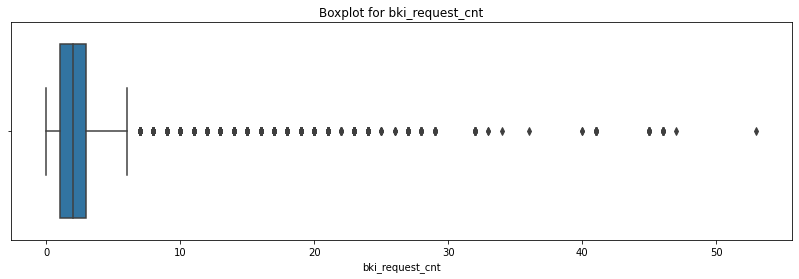

In [80]:
#for col in list_numeric:
    #fig, ax = plt.subplots(figsize = (14, 4))
    #ax.set_title('Boxplot for ' + col)
    #sns.boxplot(x=data[col])
get_boxplot(data, list_numeric)

Имеются выбросы. Прологорифмируем и приведем выбросы к нижнему и верхнему квартилю.

In [81]:
data = remove_outliers(data, list_numeric)

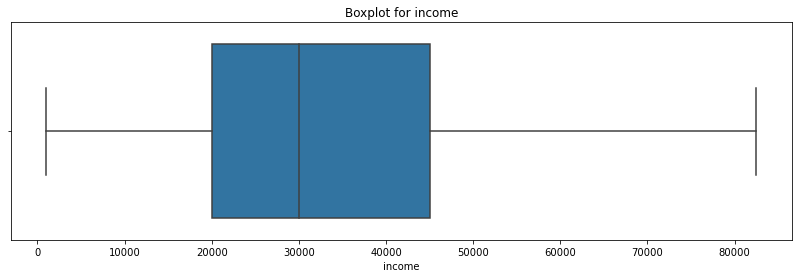

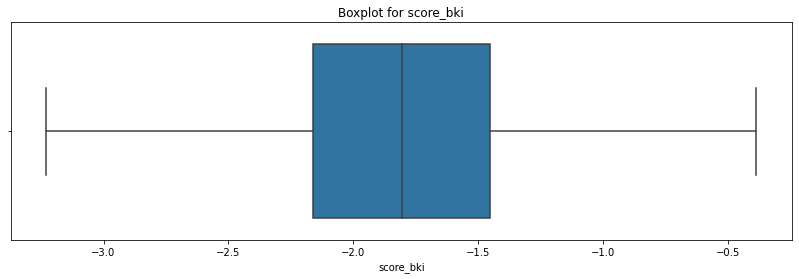

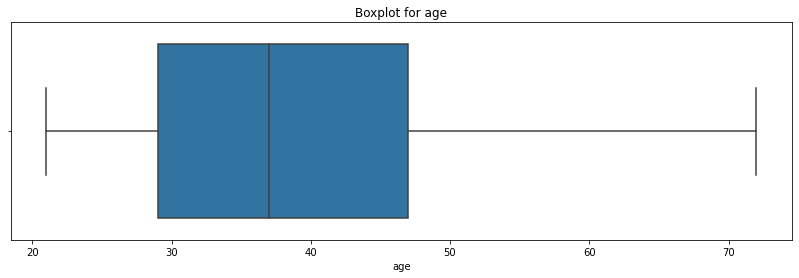

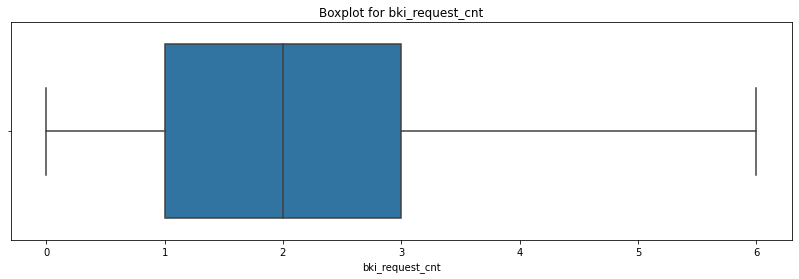

In [82]:
get_boxplot(data, list_numeric)

In [83]:
data = log_num(data, ['income', 'age', 'bki_request_cnt'])

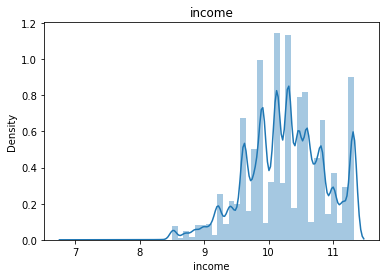

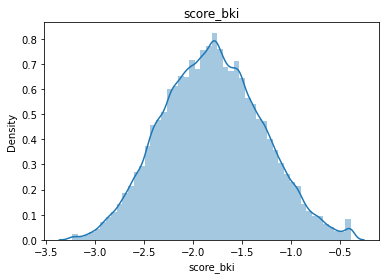

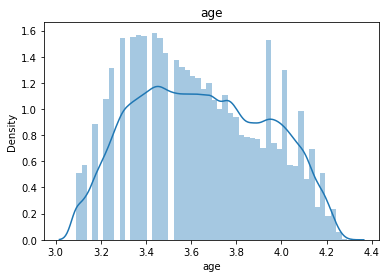

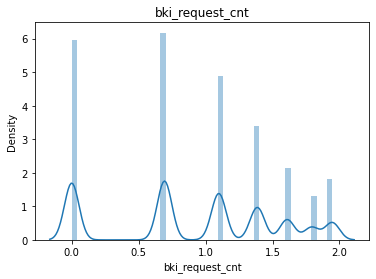

In [84]:
for col in list_numeric:
    num_hist(data[col])

bki_request_cnt имеет странное распределение

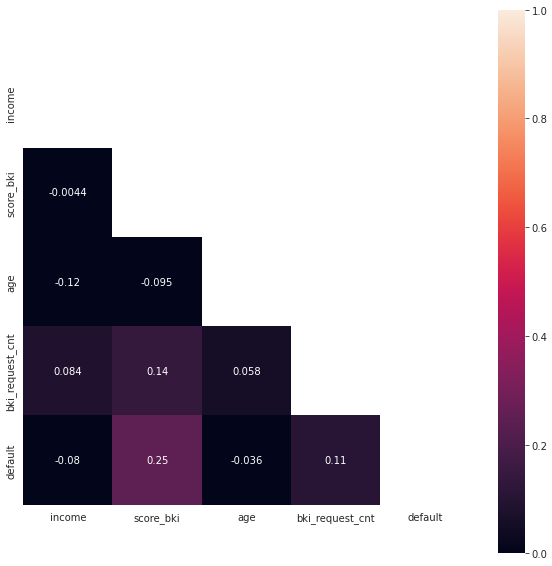

In [85]:
heatmap(data, ['income', 'score_bki', 'age', 'bki_request_cnt', 'default'], 'pearson')

Значимые корреляции между score_bki и default, что вполне логично.

In [86]:
sort_corr = data[['income', 'score_bki', 'age', 'bki_request_cnt', 'default']].corr()
sort_corr = sort_corr.default.apply(lambda x: np.abs(x))
sort_corr.sort_values(ascending=False)

default            1.000000
score_bki          0.245429
bki_request_cnt    0.107775
income             0.079595
age                0.035854
Name: default, dtype: float64

Еще раз оценим зависимости парамеров межде собой

In [88]:
#DATA_DIR = '/kaggle/input/sf-scoring/'
DATA_DIR = './data'
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

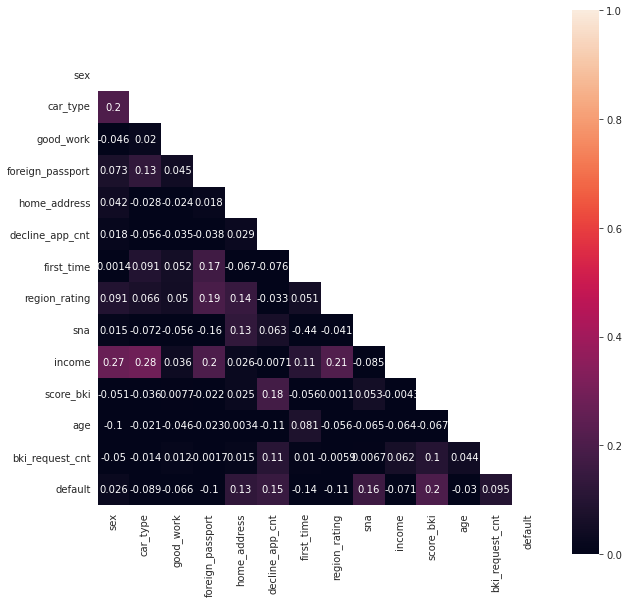

In [89]:
list_binary = ['sex', 'car_type', 'good_work', 'foreign_passport']
list_сategorical = ['home_address', 'decline_app_cnt', 'first_time',
                    'education', 'region_rating', 'sna']
list_numeric = ['income', 'score_bki', 'age', 'bki_request_cnt']
drop_list = ['client_id', 'car', 'work_address']
heatmap(data, list_binary + list_сategorical + list_numeric + ['default'], 'kendall')

Значимых корреляций необнаружено

# Data Preprocessing

In [100]:
class Data:
    def __init__(self, df_train, df_test, list_binary, list_сategorical, list_numeric, drop_list, date_column):
        self.train = df_train
        self.test = df_test
        self.list_binary = list_binary
        self.list_categorical = list_сategorical
        self.list_numeric = list_numeric
        self.drop_list = drop_list
        self.train['sample'] = 1
        self.test['sample'] = 0
        self.test['default'] = 0
        self.full_data = self.test.append(self.train, sort=False).reset_index(drop=True)
        self.date_column = date_column


    def date(self):
        self.full_data[self.date_column] = self.full_data[self.date_column].apply(lambda x: datetime.strptime(x, '%d%b%Y'))
        self.full_data['mouth'] = self.full_data[self.date_column].apply(lambda x: x.month)
        self.full_data.drop(self.date_column, axis=1, inplace=True)
       
       
    def get_dummies(self):
         self.full_data = pd.get_dummies(self.full_data, columns=self.list_categorical, dummy_na=True)
        
        
    def encoder(self):
        __label_encoder = LabelEncoder()
        for _col in self.list_binary:
            self.full_data[_col] = label_encoder.fit_transform(self.full_data[_col])


    def remove_outliers(self):
        self.full_data[self.list_numeric] = RobustScaler().fit_transform(self.full_data[list_numeric])


    def log_num(self):
        for _col in ['income', 'age', 'bki_request_cnt']:
            self.full_data[_col] = self.full_data[_col].apply(lambda x: np.log(x+1))


    def standard(self):
        self.train[self.list_numeric] = StandardScaler().fit_transform(self.train[self.list_numeric].values)
        self.test[self.list_numeric] = StandardScaler().fit_transform(self.test[self.list_numeric].values)


    def drop_column(self):
        self.full_data = self.full_data.drop(self.drop_list, axis = 1)


    def data_split(self):
        self.train = self.full_data.query('sample == 1').drop(['sample'], axis=1)
        self.test = self.full_data.query('sample == 0').drop(['sample', 'default'], axis=1)


    def preprocessing(self):
        self.date()
        self.encoder()
        self.log_num()
        self.remove_outliers()
        self.get_dummies()
        self.drop_column()
        self.data_split()
        self.standard()



In [101]:
#DATA_DIR = '/kaggle/input/sf-scoring/'
DATA_DIR = './data'
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [102]:
list_binary = ['sex', 'car_type', 'good_work', 'foreign_passport']
list_сategorical = ['home_address', 'decline_app_cnt', 'first_time',
                    'education', 'region_rating', 'sna']
list_numeric = ['income', 'score_bki', 'age', 'bki_request_cnt']
drop_list = ['client_id', 'car', 'work_address']

In [103]:
df = Data(df_train, df_test, list_binary, list_сategorical, list_numeric, drop_list, 'app_date')
df.preprocessing()
#df_train, df_test = preprocessing(df_train, df_test, list_binary, list_сategorical, list_numeric, drop_list)

In [104]:
df.train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 36349 to 110147
Data columns (total 63 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sex                   73799 non-null  int32  
 1   age                   73799 non-null  float64
 2   car_type              73799 non-null  int32  
 3   good_work             73799 non-null  int64  
 4   score_bki             73799 non-null  float64
 5   bki_request_cnt       73799 non-null  float64
 6   income                73799 non-null  float64
 7   foreign_passport      73799 non-null  int32  
 8   default               73799 non-null  int64  
 9   mouth                 73799 non-null  int64  
 10  home_address_1.0      73799 non-null  uint8  
 11  home_address_2.0      73799 non-null  uint8  
 12  home_address_3.0      73799 non-null  uint8  
 13  home_address_nan      73799 non-null  uint8  
 14  decline_app_cnt_0.0   73799 non-null  uint8  
 15  decline_app_cn

In [105]:
df.test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36349 entries, 0 to 36348
Data columns (total 62 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sex                   36349 non-null  int32  
 1   age                   36349 non-null  float64
 2   car_type              36349 non-null  int32  
 3   good_work             36349 non-null  int64  
 4   score_bki             36349 non-null  float64
 5   bki_request_cnt       36349 non-null  float64
 6   income                36349 non-null  float64
 7   foreign_passport      36349 non-null  int32  
 8   mouth                 36349 non-null  int64  
 9   home_address_1.0      36349 non-null  uint8  
 10  home_address_2.0      36349 non-null  uint8  
 11  home_address_3.0      36349 non-null  uint8  
 12  home_address_nan      36349 non-null  uint8  
 13  decline_app_cnt_0.0   36349 non-null  uint8  
 14  decline_app_cnt_1.0   36349 non-null  uint8  
 15  decline_app_cnt_2.0

# Model

In [106]:
y = df.train['default']
X = df.train.drop(['default'], axis=1)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [108]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((59039, 62), (14760, 62), (59039,), (14760,))

In [109]:
#logreg = LogisticRegression()
#logreg.fit(X_train, y_train)
#y_pred = logreg.predict(X_test)

In [110]:
#fpr, tpr, thresholds = roc_curve(y_train,logreg.predict_proba(X_train).T[1])
#roc_auc = roc_auc_score(y_train,logreg.predict_proba(X_train).T[1])   
#plt.figure(figsize=(8, 8))
#plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
#plt.title('Receiver Operating Characteristic', fontsize=15)
#plt.xlabel('False positive rate (FPR)', fontsize=15)
#plt.ylabel('True positive rate (TPR)', fontsize=15)
#plt.legend(fontsize=15)

In [111]:
#classification_report = classification_report(y_test, y_pred)
#print(classification_report)

In [112]:
#print(accuracy_score(y_test, y_pred))
#print(precision_score(y_test, y_pred))
#print(recall_score(y_test, y_pred))
#print(f1_score(y_test, y_pred))

In [113]:
model = LogisticRegression()

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]


gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_


best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l1'
	random_state: None
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False


In [114]:
model = LogisticRegression()

In [115]:
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

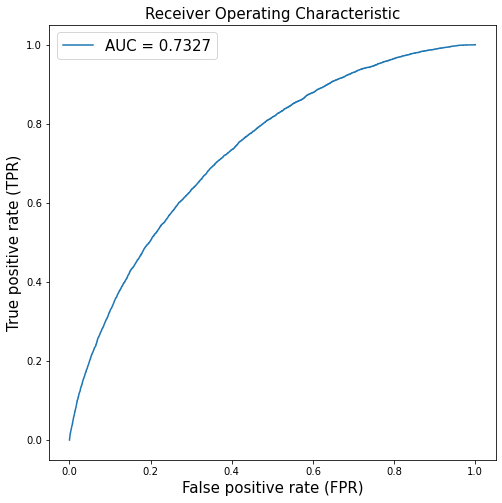

In [116]:
fpr, tpr, thresholds = roc_curve(y_train,model.predict_proba(X_train).T[1])
roc_auc = roc_auc_score(y_train,model.predict_proba(X_train).T[1])   
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.xlabel('False positive rate (FPR)', fontsize=15)
plt.ylabel('True positive rate (TPR)', fontsize=15)
plt.legend(fontsize=15)

In [117]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.6768970189701897
0.23497067448680353
0.6830047948854555
0.3496522569207691


In [118]:
kf = KFold(n_splits=10)
kfmodel = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1,
                             l1_ratio=None, max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2', 
                             random_state=None, solver='sag', tol=1e-5, verbose=0, warm_start=False)

In [119]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    kfmodel.fit(X_train, y_train)


In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_pred = kfmodel.predict(X_test)

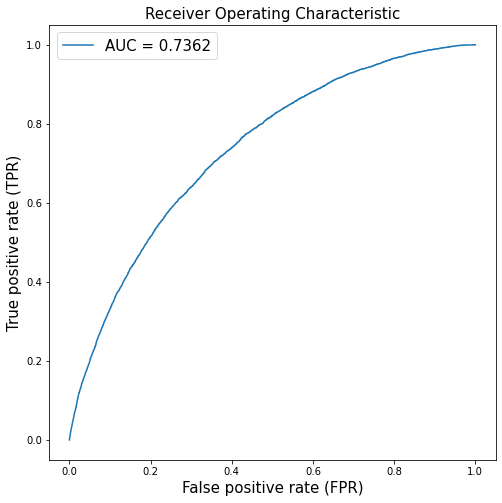

In [121]:
fpr, tpr, thresholds = roc_curve(y_train,kfmodel.predict_proba(X_train).T[1])
roc_auc = roc_auc_score(y_train,kfmodel.predict_proba(X_train).T[1])   
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.xlabel('False positive rate (FPR)', fontsize=15)
plt.ylabel('True positive rate (TPR)', fontsize=15)
plt.legend(fontsize=15)

In [122]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.6633468834688346
0.2242739333094299
0.6608557844690967
0.3348949270512649


In [123]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X, y)

In [124]:
kfmodelrus = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1,
                             l1_ratio=None, max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2', 
                             random_state=None, solver='sag', tol=1e-5, verbose=0, warm_start=False)

In [125]:
for train_index, test_index in kf.split(X_us):
    X_train, X_test = X_us.iloc[train_index], X_us.iloc[test_index]
    y_train, y_test = y_us.iloc[train_index], y_us.iloc[test_index]
    kfmodelrus.fit(X_train, y_train)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_pred = kfmodelrus.predict(X_test)

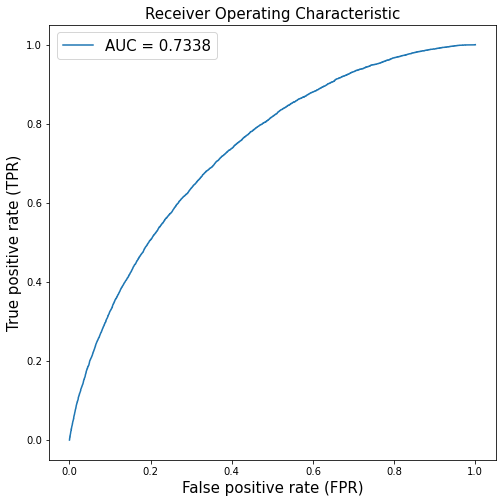

In [127]:
fpr, tpr, thresholds = roc_curve(y_train,kfmodelrus.predict_proba(X_train).T[1])
roc_auc = roc_auc_score(y_train,kfmodelrus.predict_proba(X_train).T[1])   
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.xlabel('False positive rate (FPR)', fontsize=15)
plt.ylabel('True positive rate (TPR)', fontsize=15)
plt.legend(fontsize=15)

0.6772357723577236
0.2359800111049417
0.6671899529042387
0.34864643150123054


<AxesSubplot:>

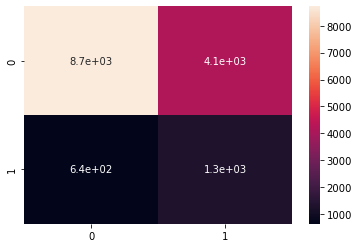

In [128]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
matrix_con = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix_con, annot=True)

In [129]:
sgd_clf = SGDClassifier(max_iter=1000) # классификатор на основе метода стохастического градиентного спуска (Stochastic Gradient Descent SGD)
skfolds = StratifiedKFold(n_splits=10)
for train, test in skfolds.split(X, y):
    X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
    sgd_clf.fit(X_train, y_train)

In [130]:
#df_train_contact = df_train[df_train.default == 1]
#for n in range(1,11):
    #df_train = pd.concat([df_train, df_train_contact])

In [131]:
y = df.train['default']
X = df.train.drop(['default'], axis=1)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_pred = sgd_clf.predict(X_test)

In [133]:
#fpr, tpr, thresholds = roc_curve(y_train,sgd_clf.predict(X_train).T[1])
#roc_auc = roc_auc_score(y_train,sgd_clf.predict(X_train).T[1])   
#plt.figure(figsize=(8, 8))
#plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
#plt.title('Receiver Operating Characteristic', fontsize=15)
#plt.xlabel('False positive rate (FPR)', fontsize=15)
#plt.ylabel('True positive rate (TPR)', fontsize=15)
#plt.legend(fontsize=15)

0.8712737127371274
0.0
0.0
0.0


<AxesSubplot:>

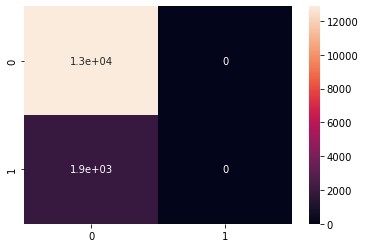

In [134]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
matrix_con = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix_con, annot=True)

Лучшие результаты показала модель "model" обученная через GridSearchCV, разбиение на большее количество частей пириводит к ухудшению показателей. SGDClassifier в итоге выдает одни нуыли, что нас не устраевет. Примем данную модель для Submission

In [135]:
df.test.shape, X.shape

((36349, 62), (73799, 62))

# Submission

In [136]:
predict_submission = model.predict(df.test)

In [137]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [138]:
!kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"

"kaggle" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
